In [4]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Show plots inside notebook
%matplotlib inline


In [5]:
# Download data for Apple (AAPL) from Yahoo Finance
data = yf.download('AAPL', start='2018-01-01', end='2023-12-31')

# Show first 5 rows
data.head()


C:\Users\dutta\AppData\Local\Temp\ipykernel_912\723911375.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', start='2018-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.426826,40.436216,39.722772,39.933990,102223600
2018-01-03,40.419788,40.964259,40.356426,40.490195,118071600
2018-01-04,40.607533,40.710794,40.384583,40.492536,89738400
2018-01-05,41.069851,41.156683,40.612216,40.703743,94640000
2018-01-08,40.917313,41.213014,40.818742,40.917313,82271200


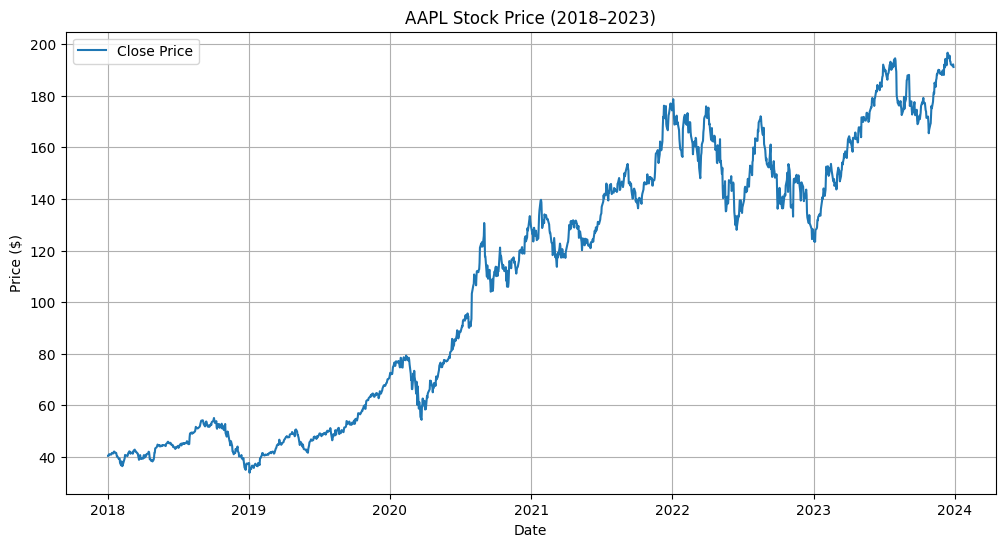

In [6]:
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Close Price')
plt.title("AAPL Stock Price (2018–2023)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# Step 2.1: Use only the 'Close' column
close_prices = data['Close']
close_prices = close_prices.values.reshape(-1, 1)  # Reshape to 2D array for scaler

# Step 2.2: Normalize using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

print("Original shape:", close_prices.shape)
print("Scaled shape:", scaled_data.shape)


Original shape: (1509, 1)
Scaled shape: (1509, 1)


In [8]:
# Use 60 previous days to predict the 61st day
sequence_length = 60
x_train = []
y_train = []

for i in range(sequence_length, len(scaled_data)):
    x_train.append(scaled_data[i-sequence_length:i, 0])
    y_train.append(scaled_data[i, 0])

# Convert to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape for LSTM: [samples, timesteps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)


x_train shape: (1449, 60, 1)
y_train shape: (1449,)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Step 3: Build the model
model = Sequential()

# Layer 1: First LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

# Layer 2: Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(units=1))  # 1 output → next day's stock price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Show model summary
model.summary()


c:\Users\dutta\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Step 4: Train the model
history = model.fit(
    x_train,
    y_train,
    epochs=25,
    batch_size=32,
    verbose=1
)


Epoch 1/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 0.0441
Epoch 2/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0042
Epoch 3/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0036
Epoch 4/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.0035
Epoch 5/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0035
Epoch 6/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0033
Epoch 7/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0028
Epoch 8/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0030
Epoch 9/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0028
Epoch 10/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0027
Epoch 11/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0028
Epoch 12/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0025
Epoch 13/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0025
Epoch 14/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0024
Epoch 15/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.0023
Epoc

In [11]:
# Step 5.1: Prepare test data (reuse last 60 days)
test_data = scaled_data[-(sequence_length + 1):]  # last 61 values
x_test = []
x_test.append(test_data[:60, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Step 5.2: Predict the next day's stock price
predicted_price_scaled = model.predict(x_test)
predicted_price = scaler.inverse_transform(predicted_price_scaled)

# Step 5.3: Also get actual price (for comparison)
actual_price = scaler.inverse_transform([test_data[60]])

print("Predicted price:", predicted_price[0][0])
print("Actual price:", actual_price[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
Predicted price: 190.25218
Actual price: 191.13034057617188


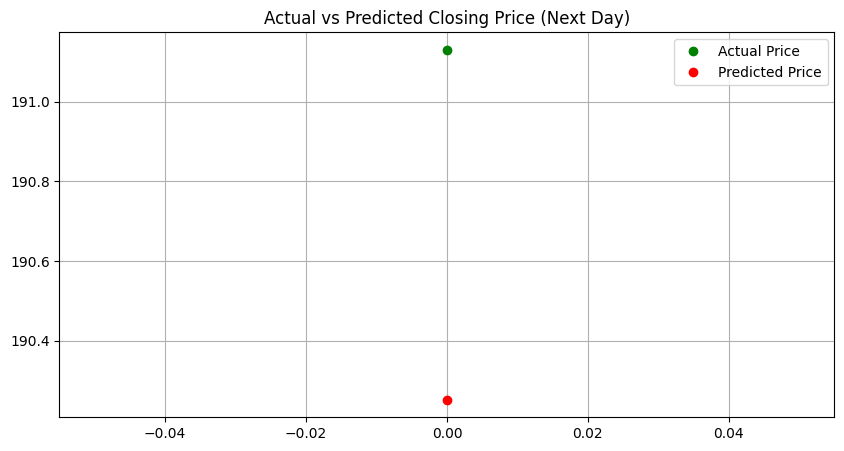

In [12]:
plt.figure(figsize=(10,5))
plt.plot([0], actual_price[0], 'go', label='Actual Price')
plt.plot([0], predicted_price[0], 'ro', label='Predicted Price')
plt.title('Actual vs Predicted Closing Price (Next Day)')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# Get last 100 days from the full scaled dataset
test_data = scaled_data[-160:]  # 100 for output, 60 for initial input

x_test = []
y_test = []

for i in range(sequence_length, len(test_data)):
    x_test.append(test_data[i-sequence_length:i, 0])
    y_test.append(test_data[i, 0])  # true value

x_test = np.array(x_test)
y_test = np.array(y_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [14]:
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


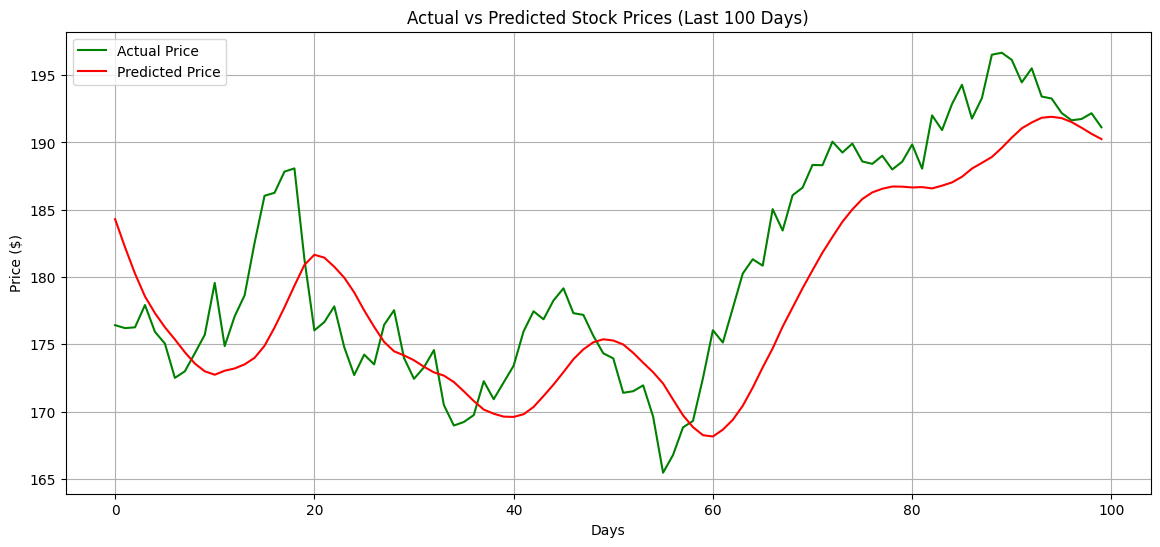

In [15]:
plt.figure(figsize=(14,6))
plt.plot(real_prices, color='green', label='Actual Price')
plt.plot(predicted_prices, color='red', label='Predicted Price')
plt.title('Actual vs Predicted Stock Prices (Last 100 Days)')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()


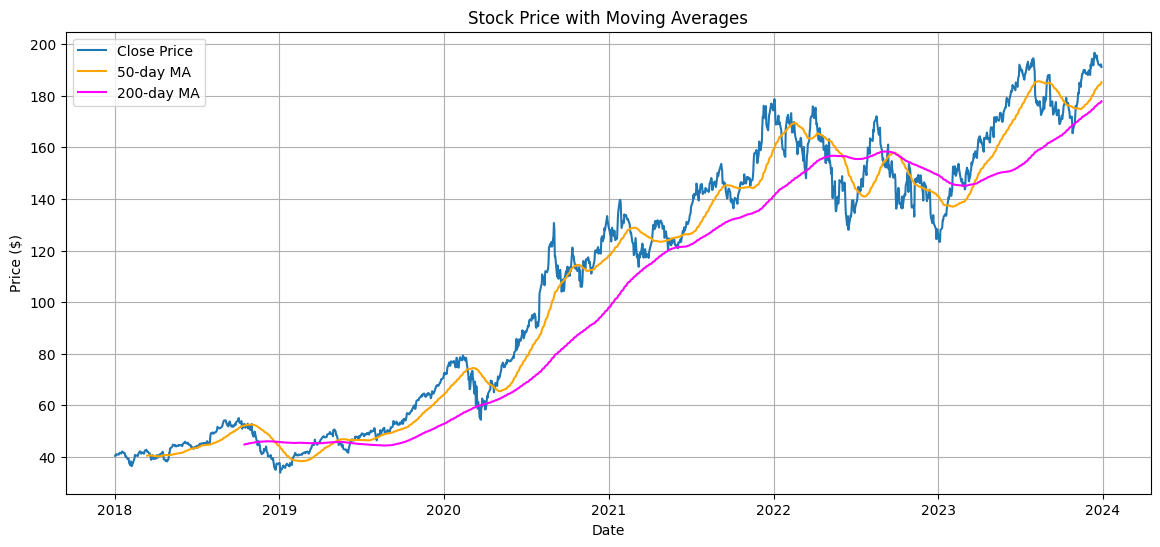

In [16]:
# Add moving averages to the original data
data['MA50'] = data['Close'].rolling(window=50).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()

# Plot with Moving Averages
plt.figure(figsize=(14,6))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['MA50'], label='50-day MA', color='orange')
plt.plot(data['MA200'], label='200-day MA', color='magenta')
plt.title('Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()



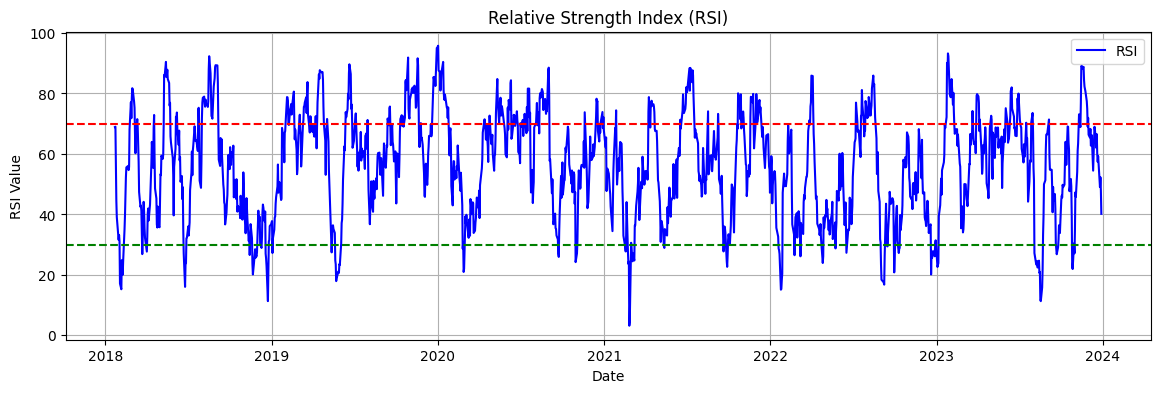

In [17]:
# RSI calculation
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

# Add to DataFrame and plot
data['RSI'] = rsi

plt.figure(figsize=(14,4))
plt.plot(data['RSI'], label='RSI', color='blue')
plt.axhline(70, color='red', linestyle='--')   # Overbought
plt.axhline(30, color='green', linestyle='--') # Oversold
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# Save model to file
model.save("stock_price_lstm_model.h5")
print("✅ Model saved as stock_price_lstm_model.h5")


✅ Model saved as stock_price_lstm_model.h5
